# Tema 4: model de regresie logistica multinomiala antrenat cu Pytorch

Implementati un model de regresie logistica multinomiala pentru clasificarea celor 10 tipuri de cifre din setul MNIST.

Puteti reutiliza si adapta cod din exemplul Pytorch pentru regresia logistica binara. 
Modificarile pe care trebuie sa le aveti in vedere sunt:
1. in definirea lui Dataset nu se mai face filtrare dupa clasele pozitive si negative; se lasa toate datele
1. In definirea clasei modelului, stratul `self.fully_connected` trebuie sa fie cu numarul de iesiri egal cu numarul de clase
1. La predictie, pentru fiecare vector de intrare (cifra reprezentata ca vector de 784 de valori) modelul produce un vector de 10 probabilitati. Clasa se decide ca indicele pe care probabilitatea este maxima. Aceasta afecteaza implementarea functiei de testare
1. Se reccomanda ca in functia `forward` a modelului sa nu se mai aplice si functia softmax, ci sa se returneze direct logitii (valoarea producsa de aplicarea stratului liniar, adica inmultirea dintre matricea de ponderi si intrare)
1. Functia de eroare `loss_fn` este `torch.nn.CrossEntropyLoss`. Aceasta preia logitii produsi de model (punctul de mai sus)

Creati o matrice de confuzie pentru clase; puteti folosi [scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). Folositi unul din optimizatorii: Adam, RMSprop, Adagrad.

Prezentati in acelasi grafic loss-ul pe setul antrenare si pe testare; intr-un alt grafic acuratetea pe setul de antrenare si pe cel de testare.

Predarea acestei aplicatii se pana in 10 aprilie ora 23, in cadrul temei 4 de pe platforma. Modul de predare si de rpezentare aeste la fel ca pentru temele precedente.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

from torchinfo import summary

# importam clasa de baza Dataset:
from torch.utils.data import Dataset

# pentru citire de fisier cvs, verificare cai etc:
import pandas as pd
import os
from typing import Tuple, List

Using PyTorch version: 2.2.2+cu121  Device: cuda:0


In [16]:
class MNISTDataset(Dataset):
    def __init__(self, path_csv: str, transform=None):
        """
        Initializare dataset folosind fisierul csv cu datele MNIST
        :param path_csv: calea catre fisierul csv
        :param transform: transformari aplicate pe datele din dataset (niciuna in cazul nostru)
        """
        # apelam constructorul clasei de baza
        super(MNISTDataset, self).__init__()
        assert os.path.exists(path_csv), f"Fisierul {path_csv} nu exista"
        self.path_csv:str = path_csv
        _all_digits: np.ndarray = pd.read_csv(path_csv, header=None).values
        # etichtele sunt primele coloane
        self.labels: np.ndarray = _all_digits[:, 0]
        # pixelii sunt restul coloanelor
        self.pixels: np.ndarray = _all_digits[:, 1:]
        # scalam pixelii in [0, 1]
        self.pixels: np.ndarray = self.pixels / 255.0

        # conversie la torch.Tensor
        self.pixels: torch.Tensor = torch.Tensor(self.pixels)
        self.labels: torch.Tensor = torch.Tensor(self.labels)

        # transformari aplicate pe date
        self.transform = transform
    
    def __len__(self) -> int:
        """
        Returneaza numarul de exemple din dataset
        :return: numarul de exemple din dataset
        """
        return len(self.labels)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returneaza perechea imagine, eticheta de la indexul idx
        :param idx: indexul imaginii
        :return: perechea imagine, eticheta
        """
        image: torch.Tensor = self.pixels[idx]
        label: torch.Tensor = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [17]:
train_dataset = MNISTDataset(path_csv='./data/mnist_train.csv')
test_dataset = MNISTDataset(path_csv='./data/mnist_test.csv')

In [18]:
# importam clasa DataLoader
from torch.utils.data import DataLoader

# dimensiunea unui batch
batch_size = 64 # 64 de imagini si 64 de etichete
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
print(train_dataset.__len__())
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print(test_dataset.__len__())

for data, label in train_loader:
    print(data.shape, label.shape)
    break

60000
10000
torch.Size([64, 784]) torch.Size([64])


In [19]:
# definim modelul
class MultinomialLogisticRegression(nn.Module):
    def __init__(self, input_dim: int = 784):
       """ 
       Intializarea unui model de regresie logistica multinomiala
       :param input_dim: dimensiunea imaginii(vectorului) de intrare. In cazul nostru 28*28=784
       """
       # apelam constructorul clasei de baza
       super().__init__()
       self.input_dim = input_dim
       # initializam ponederile ca o matrice de 10 linii si 784 coloane
       self.fully_connected: nn.Linear = nn.Linear(in_features=input_dim, out_features=10, bias=True)
    #    self.linear1 = nn.Linear(input_dim, 100)  # First linear layer
    #    self.linear2 = nn.Linear(100, 10)  # Second linear layer

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Calculul iesirii modelului pentru un batch de imagini
        :param x: un batch de imagini de dimensiunea (batch_size, 1, 28, 28)
        :return: un batch de iesiri de dimensiunea (batch_size, 10)
        """
        # # redimensionam imaginile in forma (batch_size, 784)
        x = x.view(-1, self.input_dim)
        # aplicam regresia logistica
        x = self.fully_connected(x)

        # x = self.linear1(x)
        # x = torch.relu(x) # Aplicam functia de activare ReLU
        # x = self.linear2(x)
        return x

In [20]:
model = MultinomialLogisticRegression(input_dim=784)
print(model)
summary(model)

MultinomialLogisticRegression(
  (fully_connected): Linear(in_features=784, out_features=10, bias=True)
)


Layer (type:depth-idx)                   Param #
MultinomialLogisticRegression            --
├─Linear: 1-1                            7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0

In [21]:
print(f'device: {device}')
model.to(device)

device: cuda:0


MultinomialLogisticRegression(
  (fully_connected): Linear(in_features=784, out_features=10, bias=True)
)

In [22]:
# for param in model.parameters():
#     print(param.grad_fn, param.requires_grad)

# # setam modelul in modul de antrenare
# model.train()

# for x, y in train_loader:
#     # datele si modelul trebuie sa fie pe acelasi device, altfel calculele nu se pot efectua
#     x, y = x.to(device), y.to(device)
    
#     # produce predictia, tensor plin cu probabilitati
#     y_hat = model(x).squeeze()
#     print(f'Predictii (probabilitati): {y_hat}')

#     # show grad_fn for y_hat
#     print(f'grad_fn for y_hat: {y_hat.grad_fn}')
    
#     # daca probabilitatea conditionata este >= 0.5, atunci modelul prezice clasa pozitiva (1), altfel 0 
#     clase = torch.argmax(y_hat, dim=1)
#     print(f'Clase prezise: {clase}')
    
    
#     # ne oprim dupa primul minibatch aici, e doar pentru a vedea cum arata predictiile facute de model
#     break 




In [23]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [24]:
# dezactivam urmarirea automata a tensorilor pentru care se pot calcula gradientii:
# gradientii sunt necesari doar la antrenare, nu si la testare
@torch.no_grad()
def test(model: nn.Module, test_loader: DataLoader, device: torch.device) -> Tuple[float, float]:
    """
    Testarea modelului pe datele din :param test_loader:
    :param model: modelul de regresie logistica multinomiala
    :param test_loader: dataloader pentru datele de test
    :param device: dispozitivul pe care ruleaza modelul (cpu sau cuda)
    :return: acuratetea modelului pe datele de test
    """
    # setam modelul in modul de evaluare
    model.eval()
    # initializam numarul de predictii corecte
    correct = 0
    # initializam numarul total de exemple
    total = 0
    # initializam loss-ul total
    total_loss = 0
    # parcurgem datele de test
    for images, labels in test_loader:
        # mutam datele pe device
        images, labels = images.to(device), labels.to(device)
        # calculam iesirile modelului
        outputs = model(images).squeeze()
        # determinam clasa prezisa
        _, predicted = torch.max(outputs.data, 1)
        # incrementam numarul de exemple
        total += labels.size(0)
        # incrementam numarul de predictii corecte
        correct += (predicted == labels).sum().item()

        # calculam loss-ul
        loss = loss_fn(outputs, labels.long())
        # incrementam loss-ul total
        total_loss += loss.item()*len(labels)
    # returnam acuratetea modelului si loss-ul mediu
    return correct / total, total_loss/total

In [25]:
acc,_ = test(model, test_loader, device)
print(f'Acuratetea modelului este: {acc*100:.4f}%')

Acuratetea modelului este: 9.6800%


In [30]:
# epoci de antrenare
num_epochs: int = 30

losses_test: List = []
losses_train: List = []
accuracies_test: List = []
accuracies_train: List = []

def train(model: nn.Module, train_loader: DataLoader, test_loader: DataLoader, optimizer: torch.optim.Optimizer, 
          loss_fn: nn.Module, num_epochs: int, device: torch.device) -> Tuple[List, List, List, List]:
    """
    Antrenarea modelului de regresie logistica multinomiala
    :param model: modelul de regresie logistica multinomiala
    :param train_loader: dataloader pentru datele de antrenare
    :param test_loader: dataloader pentru datele de test
    :param optimizer: optimizatorul folosit pentru antrenare
    :param loss_fn: functia de loss folosita pentru antrenare
    :param num_epochs: numarul de epoci de antrenare
    :param device: dispozitivul pe care ruleaza modelul (cpu sau cuda)
    """
    # initializam listele pentru loss si acuratete
    losses_test: List = []
    losses_train: List = []
    accuracies_test: List = []
    accuracies_train: List = []
    # parcurgem epocile
    for epoch in range(num_epochs):
        # setam modelul in modul de antrenare
        model.train()
        epoch_loss: float = 0.0
        total_samples: int = 0
        correct_samples: int = 0
        acc_train: float = 0.0
        for images, labels in train_loader:
            # mutam datele pe device-ul pe care ruleaza modelul
            images, labels = images.to(device), labels.to(device)
            # resetam gradientii calculati anterior, pentru a nu se acumula (deci, pentru a nu se aduna la fiecare pas de antrenare)
            optimizer.zero_grad()
            # calculam iesirile modelului
            outputs = torch.squeeze(model(images))
            # calculam eroarea
            loss = loss_fn(outputs, labels.long())
            # pierderea calculata este o medie pe batch, asa ca trebuie sa o inmultim cu dimensiunea batch-ului
            #epoch_loss += loss.item() * len(labels)
            # acumulam numarul de exemple
            #total_samples += len(labels)
            # calculam gradientii
            loss.backward()
            # actualizam ponderile aplicand gradientii pe baza optimizatorului = invatam
            optimizer.step()

            # calculam acuratetea pe batch-ul curent
            #_, predicted = torch.max(outputs.data, 1)
            #correct_samples += (predicted == labels).sum().item()

        # calculam acuratetea pe datele de antrenare
        # acc_train = correct_samples / total_samples
        accuracies_train.append(acc_train)
        # calculam pierderea medie pe epoca
        # epoch_loss /= total_samples
        # losses_train.append(epoch_loss)
        acc_test, loss_test = test(model, test_loader, device)
        acc_train, loss_train = test(model, train_loader, device)
        accuracies_test.append(acc_test)
        losses_test.append(loss_test)
        losses_train.append(loss_train)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {np.mean(loss_train):.4f}, Accuracy: {acc_test*100:.4f}%')
    return losses_train, accuracies_train, losses_test, accuracies_test

losses_train, accuracies_train, losses_test, accuracies_test = \
    train(model, train_loader, test_loader, optimizer, loss_fn, num_epochs, device)


Epoch 1/30, Loss: 0.2529, Accuracy: 92.5300%
Epoch 2/30, Loss: 0.2471, Accuracy: 92.8100%
Epoch 3/30, Loss: 0.2449, Accuracy: 92.5700%
Epoch 4/30, Loss: 0.2434, Accuracy: 92.9200%
Epoch 5/30, Loss: 0.2442, Accuracy: 92.7400%
Epoch 6/30, Loss: 0.2435, Accuracy: 92.7700%
Epoch 7/30, Loss: 0.2419, Accuracy: 92.7000%
Epoch 8/30, Loss: 0.2408, Accuracy: 92.6300%
Epoch 9/30, Loss: 0.2410, Accuracy: 92.7800%
Epoch 10/30, Loss: 0.2393, Accuracy: 92.6400%
Epoch 11/30, Loss: 0.2388, Accuracy: 92.9100%
Epoch 12/30, Loss: 0.2363, Accuracy: 92.9600%
Epoch 13/30, Loss: 0.2371, Accuracy: 92.8000%
Epoch 14/30, Loss: 0.2353, Accuracy: 92.8300%
Epoch 15/30, Loss: 0.2339, Accuracy: 92.7700%
Epoch 16/30, Loss: 0.2347, Accuracy: 92.8500%
Epoch 17/30, Loss: 0.2336, Accuracy: 92.7700%
Epoch 18/30, Loss: 0.2326, Accuracy: 92.7800%
Epoch 19/30, Loss: 0.2339, Accuracy: 92.7200%
Epoch 20/30, Loss: 0.2346, Accuracy: 92.8300%
Epoch 21/30, Loss: 0.2326, Accuracy: 92.8300%
Epoch 22/30, Loss: 0.2338, Accuracy: 92.650

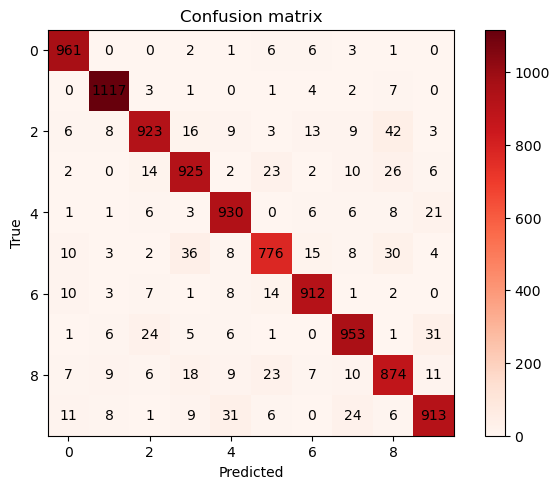

44305


In [ ]:
from sklearn.metrics import confusion_matrix

def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

# Calculate predictions
model.eval()
test_preds = get_all_preds(model, test_loader)
test_preds = torch.argmax(test_preds, dim=1).cpu().numpy()
test_labels = [label for _, label in test_dataset]

# Calculate confusion matrix
cm = confusion_matrix(test_labels, test_preds)
# print(cm)

# Plot confusion matrix
#show the annotation
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
for i in range(10):
    for j in range(10):
        plt.text(j, i, f'{cm[i, j]}', ha='center', va='center')
plt.title('Confusion matrix')
plt.colorbar()
plt.tight_layout()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(test_preds.sum())


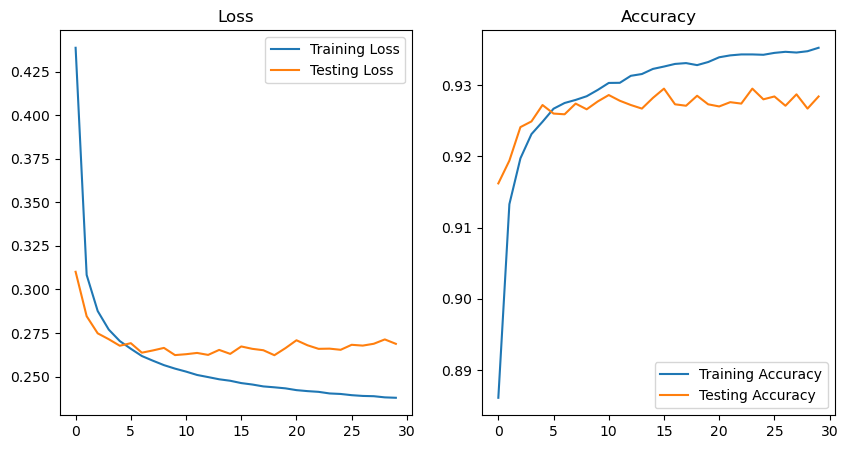

Accuracies: [0.8861166666666667, 0.9132833333333333, 0.9197166666666666, 0.9231166666666667, 0.92485, 0.9266833333333333, 0.9274833333333333, 0.9279166666666666, 0.9284333333333333, 0.9293166666666667, 0.9303, 0.9303166666666667, 0.9313, 0.93155, 0.9322666666666667, 0.9326, 0.9329666666666667, 0.9330833333333334, 0.9328, 0.9332333333333334, 0.9339, 0.9341666666666667, 0.9343, 0.9343, 0.93425, 0.9345166666666667, 0.9346666666666666, 0.9345666666666667, 0.93475, 0.9352333333333334]
Losses: [0.4386348861058553, 0.3083073714733124, 0.28760973642667137, 0.2769689560890198, 0.27038699916998543, 0.26595197189648945, 0.26179198552767435, 0.25910640482505165, 0.2565621331810951, 0.2545632120807966, 0.2528544174313545, 0.2509281855901082, 0.2497069167494774, 0.24844713164965312, 0.2476023829658826, 0.2462659769932429, 0.2454458619236946, 0.24436092501084009, 0.2438429224451383, 0.24324733912944793, 0.242221071656545, 0.24165562740564347, 0.24124316288232803, 0.24032120341857274, 0.24002541313966

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses_train, label='Training Loss')
plt.plot(losses_test, label='Testing Loss')

plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies_train, label='Training Accuracy')
plt.plot(accuracies_test, label='Testing Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

# print all accuracy values and loss values with 4 decimal places
print(f'Accuracies: {accuracies_train}')
print(f'Losses: {losses_train}')

# print the final accuracy and loss values with 4 decimal places
print(f'Test accuracies: {accuracies_test}')
print(f'Test losses: {losses_test}')
